In [1]:
import os
import glob
import pickle
import numpy as np
from mne import viz
from scipy import io, stats
from matplotlib import colors, pyplot as plt

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.01

PROJECT_PATH = '..\\data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '..\\results\\new_scores{dose}'.format(dose=CAF_DOSE)

STAGES = ['AWA', 'AWSL', 'NREM', 'REM']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
scores_list = []
# load all score files from the results path and append to a list
for path in glob.glob(os.path.join(RESULTS_PATH, '*')):
    with open(path, 'rb') as file:
        scores_list.append(pickle.load(file))

In [5]:
# initialize dicts
acc_avg = {}
significant = {}
pvalues = {}

for stage in STAGES:
    # initialize dicts with more dicts
    acc_avg[stage] = {}
    significant[stage] = {}
    pvalues[stage] = {}
    
    for score in scores_list:
        for feature in score[stage].keys():
            # get accuracy and p-value for all electrodes of one feature of one estimator in one stage
            acc = np.array([curr[0] for curr in score[stage][feature]])
            curr_p = np.array([curr[2] for curr in score[stage][feature]])
            
            if feature in acc_avg[stage]:
                # add current accuracy to the overall average accuracy dict and p-value to the list in the p-value dict
                acc_avg[stage][feature] += acc / len(scores_list)
                pvalues[stage][feature].append(curr_p)
            else:
                # average accuracy dict and p-value dict are empty, initialize with first values
                acc_avg[stage][feature] = acc / len(scores_list)
                pvalues[stage][feature] = [curr_p]
    
    for feature in score[stage].keys():
        pvalues[stage][feature] = np.array(pvalues[stage][feature])
        significant[stage][feature] = np.empty(pvalues[stage][feature].shape[1])
        
        for i in range(len(pvalues[stage][feature])):
            # combine p-values of the different classifiers with Fischer's method (https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.combine_pvalues.html)
            significant[stage][feature][i] = stats.combine_pvalues(pvalues[stage][feature][:,i])[1]

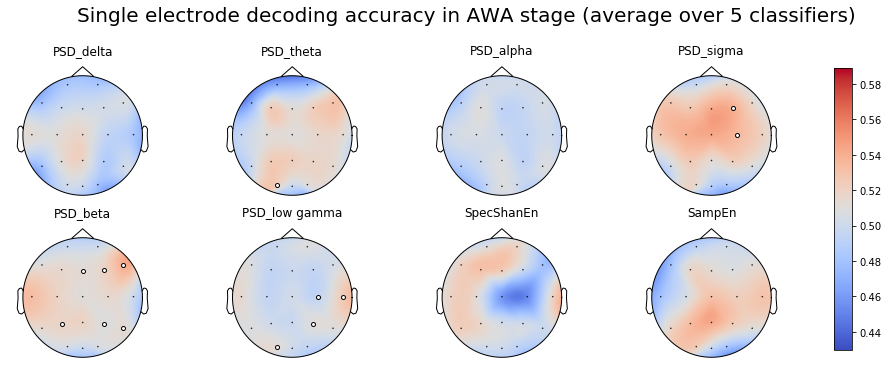

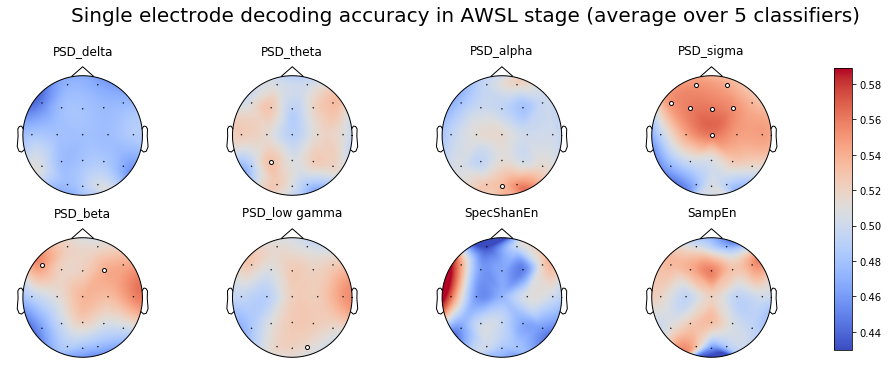

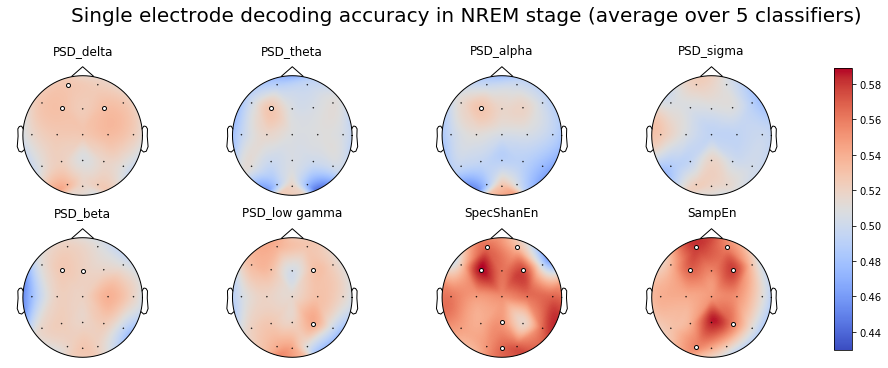

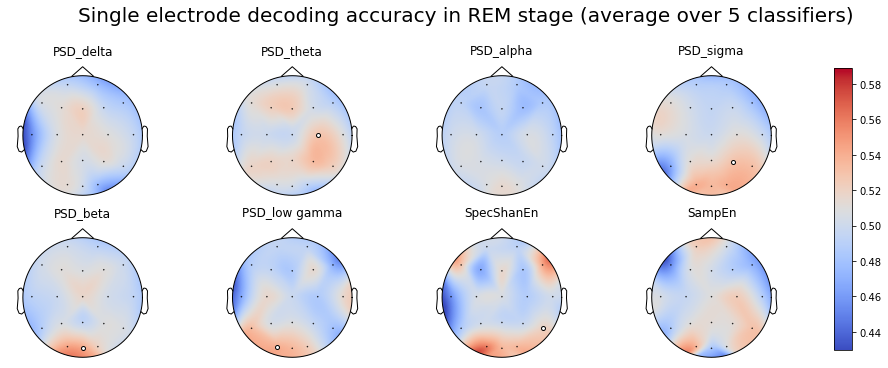

In [6]:
colormap = 'coolwarm'

# get minimum and maximum values over all features and stages for colorbar
all_scores = [[[elec for elec in val] for ft, val in acc_avg[stage].items() if not ft == 'SpecPermEn' and not ft == 'SpecSampEn'] for stage in STAGES]
vmin = np.min(all_scores)
vmax = np.max(all_scores)

for stage in STAGES:
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Single electrode decoding accuracy in {stage} stage (average over {len(scores_list)} classifiers)', y=1.1, fontsize=20)
    
    subplot_index = 1
    axes = []
    for feature in acc_avg[stage].keys():
        # skip SpecPermEN and SpecSampEn in visualization
        if feature == 'SpecPermEn' or feature == 'SpecSampEn':
            continue
        
        curr_acc = acc_avg[stage][feature]
        mask = significant[stage][feature] < SIGNIFICANT_P
        
        # add a new subplot
        axes.append(plt.subplot(2, 4, subplot_index))
        plt.title(feature)
        
        # plot the current topomap
        viz.plot_topomap(curr_acc, sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, mask=mask, contours=False, show=False)
        subplot_index += 1

    # add a colorbar to the figure
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
    plt.show()